## stereo camera depth estimation with opencv


In the making a low cost stereo camera using OpenCV article of the Introduction to spatial AI series, we created a custom low- cost stereo camera. We also discussed stereo rectification and calibration. Stereo rectification and calibration are performed to make the epipolar lines horizontal. These calculations make it easy to find dense correspondence.

This post discusses Block Matching and Semi-Global Block Matching methods to find dense correspondence and a disparity map for a rectified stereo image pair. We will also learn how to find depth maps from the disparity map. Finally, we will look at how to use depth estimation to create an obstacle avoidance system.

### Block Matching For Dense Stereo Correspondence
Given we have a horizontal stereo camera setup, the corresponding points for a rectified stereo image pair would have the same Y coordinate. So how do we go about finding the corresponding points?

One can think of a naive approach to compare the pixel values in the same row of the stereo image pair. However, this is not a robust method. Multiple pixels corresponding to different images can have the same pixel intensity. Moreover, considering practical constraints such as differences in the imaging sensors or exposure values, corresponding pixels may have unequal pixel values.

Block Matching Algo:

A better approach is to consider some **neighboring pixels** as well.
This is what we do in the block-matching algorithm. The row which we scan for stereo correspondence is called **scanline**. This sounds great! But how do we quantify the best match? Is there any metric that can be used to quantify how well the windows match?

There are multiple metrics, such as
* the Sum of Absolute Differences (SAD),
* Sum of Squared Differences (SSD), and
* Normalized Cross Correlation (NCC),
that can be used to quantify the match.

For example, the pair with the lowest SAD score is the best match, as the overall pixel-wise sum is the least. Figure 1 shows the scanline and reference block in the stereo image pair. The plot for SAD of the respective scanline is shown in the rightmost image.

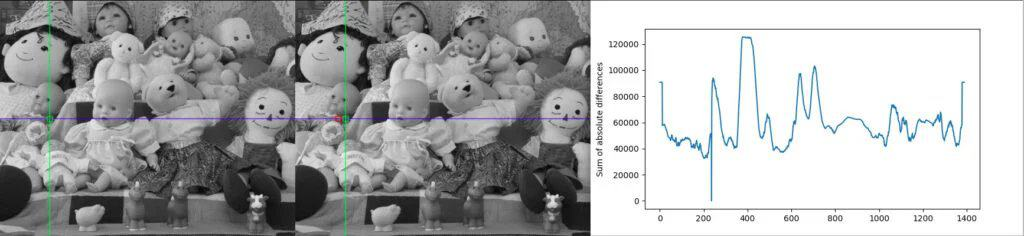

Figure 1 – Left image shows the scanline along with the target window.
Center image shows the scanline (blue), best matching block (green) and second best matching block(red).
The right image is the plot for Sum of Absolute Difference (SAD) between the reference block from the left image, and the sliding window along the scanline in the right image.

The above method gives us only one corresponding pair. We want to find correspondence for all the pixels on the scanline. A straightforward solution is to repeat the process for all the pixels on the scanline. However, this will lead to a noisy output. Practically it is impossible to get a one-to-one correspondence for any scanline. There can be multiple matches for a given block (in case of repeating texture or texture-less regions), or there can be no ideal match (due to occlusion).

### Dynamic Programming and the Scanline
Dynamic programming is a standard method to enforce a scanline’s one-to-one correspondence. The aim is to find the one-to-one correspondence for the scanline, which results in the least possible overall cost, so we overcome the practical challenges mentioned above.

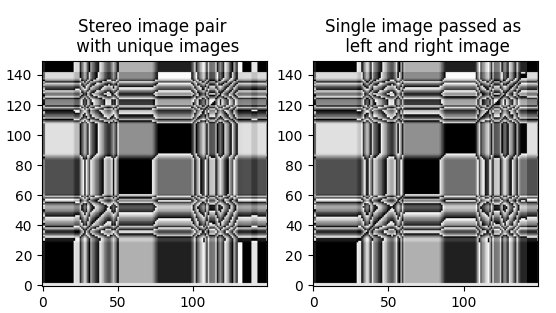

Figure 2 – Sum of Absolute Differences (SAD) values for a given scanline.


Figure 2 shows SAD values for a given scanline. The left figure corresponds to a stereo image pair of unique images, and the right figure shows the SAD values for the same scanline when a single image is used, passing it twice for comparison.

### SAD Values Explained
Brighter values represent a greater mismatch, and darker values represent a better match. To find the correspondence, we need to find the path from the bottom left corner to the top right corner such that the sum of values covered by the path is minimum. In the case of the right image of Figure 2, such a path is clearly visible along the diagonal (a thin black line from the bottom left corner to the top right corner). In the case of the left figure, the diagonal line contains some brighter values as well (due to occlusion, there is no matching block hence even the least SAD value is relatively bright).

OpenCV provides an implementation for the Block Matching algorithm – StereoBM class. The method of the StereoBM class calculates a disparity map for a pair of rectified stereo images. Various combinations of a stereo camera setup are possible depending on the type of camera sensors, the distance between the cameras, and many other factors. Hence, a fixed set of parameters cannot give good quality of disparity map for all possible combinations of a stereo camera setup.

###we can tune the param's

Understanding The Effect of Each Parameter:

- A number of disparities (numDisparities): Sets the range of disparity values to be searched. The overall range is from minimum to minimum disparity value + several disparities. The following images show the disparity map calculated for two different disparity ranges. It is clearly visible that increasing the number of disparities increases the accuracy of the disparity map.

- Block size (blockSize): Size of the sliding window used for block matching to find corresponding pixels in a rectified stereo image pair. A higher value indicates a larger window size. The following GIF indicates that increasing this parameter results in more smooth disparity maps.
- Pre-Filter Type (preFilterType): Parameter to decide the type of pre-filtering to be applied to the images before passing to the block matching algorithm. This step enhances the texture information and improves the results of the block-matching algorithm. The filter type can be CV_STEREO_BM_XSOBEL or CV_STEREO_BM_NORMALIZED_RESPONSE.
- Pre-filter size (preFilterSize): Window size of the filter used in the pre-filtering stage.
- Pre-filter cap (preFilterCap): Limits the filtered output to a specific value.
- Minimum disparity (minDisparity): The minimum value of the disparity to be searched. In most scenarios it is set to zero. It can also be set to negative value depending on the stereo camera setup.
- Texture threshold (textureThreshold): Filters out areas that do not have enough texture information for reliable matching.
- Uniqueness Ratio (uniquenessRatio): Another post-filtering step. The pixel is filtered out if the best matching disparity is not sufficiently better than every other disparity in the search range. The following GIF depicts that increasing the uniqueness ratio increases the number of pixels that are filtered out.
- Speckle range (speckleRange) and speckle window size (speckleWindowSize): Speckles are produced near the boundaries of the objects, where the matching window catches the foreground on one side and the background on the other. To get rid of these artifacts, we apply speckle filter which has two parameters. The speckle range defines how close the disparity values should be to be considered as part of the same blob. The speckle window size is the number of pixels below which a disparity blob is dismissed as “speckle”.
- disp12MaxDiff: Pixels are matched both ways, from the left image to the right image and from the right image to left image. disp12MaxDiff defines the maximum allowable difference between the original left pixel and the back-matched pixel.

### Extra ref's:
A significant point to note is that the method of the block matching class returns a 16-bit signed single-channel image containing disparity values scaled by 16. Hence, to get the actual disparity values from such fixed-point representation, we need to divide the disparity values by 16.

OpenCV also provides StereoSGBM, which implements Hirschmüller’s original SGM [2] algorithm. SGBM stands for Semi-Global Block Matching. It also implements the sub-pixel estimation proposed by Brichfield et al. [3]

In the case of simple block matching, sometimes using the minimum cost can give wrong matches.  Note that wrong matches can have a lower cost than correct matches. Hence SGBM applies additional constraints to increase smoothness by penalizing changes of disparities in the 8-connected neighborhood. For the constraint, 1-D minimum cost paths from multiple directions are aggregated.

The block-matching-based algorithms are classical computer vision algorithms. After the advent of deep neural networks, several deep learning architectures have been proposed to find dense correspondence between a stereo image pair. For further details, refer to our article on stereo matching.

### From disparity map to depth map
Till now, the grayscale  images we have been obtaining are just the disparity maps and not the depth maps. Using block matching methods, we calculated dense correspondences for a rectified stereo image pair.. We calculated the disparity for each pixel with the help of these dense correspondences ( shift between the corresponding pixels). Our earlier article on epipolar geometry provides a good intuition of how disparity is related to depth.

In this post, we improve our understanding of how depth relates to disparity and derive an expression for calculating depth from disparity. The following figure helps visualize the derivation of the expression.

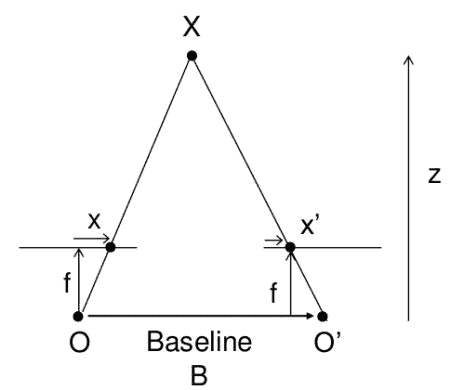
Figure 5– Figure showing the relation between depth Z and disparity (x – x’).

From the above figure, we can derive the relation between disparity (x – x’) and depth Z as follows:

(1) \begin{equation*} disparity = x - x' = \frac{Bf}{Z} \end{equation*}
Here B is the baseline of the stereo camera setup, and f is the focal length.

Now in the case of a practical setup, the focal length f of both the cameras is not identical, and moreover, manually measuring B can also lead to errors. This leads us to an important question – what should be the value of f and B, and how do we derive it?

We derive it experimentally. The above equation can also be written as follows:

(2) \begin{equation*} x-x' = M \frac{1}{Z} \end{equation*}
Where

(3) \begin{equation*} Bf = M  \end{equation*}
By creating a GUI that displays a targeted pixel’s disparity values, we can practically measure its distance from the camera (Z).  Based on multiple disparity readings and Z (depth), we can solve for M by formulating a least-squares problem.  The following graphs depict the relation between depth and disparity for a stereo camera setup highlighting the data points obtained from different observations.

Stereo Camera Depth Estimation - Image with graphs, showing the relation between depth and disparity values for a stereo camera setup.

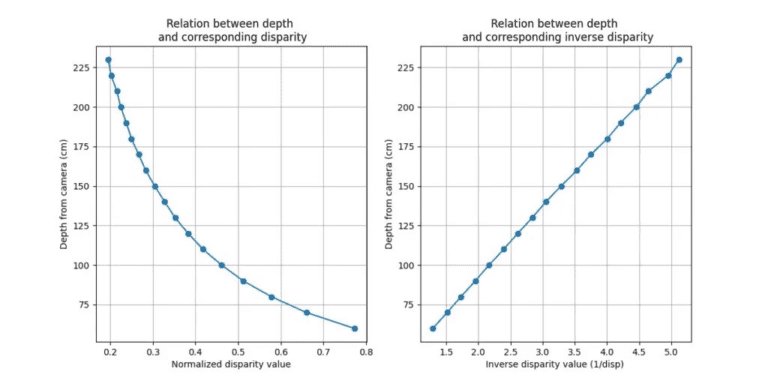

Figure 6 – Graphs showing the relation between depth and disparity values for a stereo camera setup.
Okay! The least-squares problem sounds fun. But what exactly does it mean? And how do we code it?

First, we will rearrange the previous equation as follows:

(4) \begin{equation*} Z = M \frac{1}{x-x'} \end{equation*}
By substituting

(5) \begin{equation*} \frac{1}{x-x'} = a  \end{equation*}
we get the following equation:

(6) \begin{equation*} Z = M \times a \end{equation*}
This is relatively easy, right? We need a single reading of (Z,a) to calculate M (One equation, one variable). Why do we need multiple readings, and why do we use the least-squares method? Well, this is because nothing is perfect in a practical world!

There is always a chance of error when we talk about practical scenarios. In this case, there can be a human error (in measuring the distance Z), or the disparity values calculated by the algorithm can be a bit inaccurate. Also, quantization of the disparity values induces some error. Hence, depending on a single reading is not a good idea.

So, we take multiple readings of (Z,a). Hence the number of equations exceeds the number of variables. The least-squares method helps find the value of M that best agrees with all the readings. Graphically, it is the process of finding a line such that the sum of squared distances of all the data points from the line is the least.

In [ ]:
# solving for M in the following equation
# ||    depth = M * (1/disparity)   ||
# for N data points coeff is Nx2 matrix with values
# 1/disparity, 1
# and depth is Nx1 matrix with depth values
ret, sol = cv2.solve(coeff,z,flags=cv2.DECOMP_QR)

Once we solve for M, we can convert the disparity map to the depth map by adding the following equation to our code after calculating the disparity map:

(7) \begin{equation*} depthmap = \frac{M}{disparity} \end{equation*}
The following video illustrates the process of capturing multiple readings of disparity values and corresponding depth values using the code shared with this post. It is better to take as many readings as possible for a more accurate solution.

###Obstacle avoidance system
The basic concept of obstacle avoidance is determining if the distance of any object from the sensor is closer than the minimum threshold distance. In our case, the sensor is a stereo camera.  Another type of device widely used for distance measurement and obstacle avoidance is an ultrasonic sensor.

Unlike stereo cameras, ultrasonic sensors work on the propagation of signals. A signal of known frequency is emitted. It travels until an object obstructs its path. It gets reflected from the object, and the sensor receives the reflected signal.  If the signal’s speed is known, the time elapsed between the transmission and receiving of the signal can be used to calculate the object’s distance from the sensor. Bats use a similar method to navigate and avoid obstacles.

A stereo camera’s key advantage over an ultrasonic sensor is that the stereo camera provides a greater field of view.

Steps to build an obstacle avoidance system
So how do we create an obstacle avoidance system using a stereo camera? The steps to build such a system are as follows:

1. Get the depth map from the stereo camera.
2. Based on a threshold (minimum depth value), determine regions in the depth map with a depth value less than the threshold. Using the inRange() method, create a mask to segment such regions.
3. Apply contour detection and find the largest contour.
4. Create a new mask using the largest contour.
5. Find the average depth value using the meanStdDev() method using the mask created in step 4.
6. Perform the warning action. In our example, we display the distance of the obstacle in red color.

In [ ]:
depth_thresh = 100.0 # Threshold for SAFE distance (in cm)

# Mask to segment regions with depth less than threshold
mask = cv2.inRange(depth_map,10,depth_thresh)

# Check if a significantly large obstacle is present and filter out smaller noisy regions
if np.sum(mask)/255.0 > 0.01*mask.shape[0]*mask.shape[1]:

  # Contour detection
  contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(contours, key=cv2.contourArea, reverse=True)

  # Check if detected contour is significantly large (to avoid multiple tiny regions)
  if cv2.contourArea(cnts[0]) > 0.01*mask.shape[0]*mask.shape[1]:

    x,y,w,h = cv2.boundingRect(cnts[0])

    # finding average depth of region represented by the largest contour
    mask2 = np.zeros_like(mask)
    cv2.drawContours(mask2, cnts, 0, (255), -1)

    # Calculating the average depth of the object closer than the safe distance
    depth_mean, _ = cv2.meanStdDev(depth_map, mask=mask2)

    # Display warning text
    cv2.putText(output_canvas, "WARNING !", (x+5,y-40), 1, 2, (0,0,255), 2, 2)
    cv2.putText(output_canvas, "Object at", (x+5,y), 1, 2, (100,10,25), 2, 2)
    cv2.putText(output_canvas, "%.2f cm"%depth_mean, (x+5,y+40), 1, 2, (100,10,25), 2, 2)

else:
  cv2.putText(output_canvas, "SAFE!", (100,100),1,3,(0,255,0),2,3)

cv2.imshow('output_canvas',output_canvas)